In [ ]:
# Cellule 1: Importation des bibliothèques
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.models import load_model
from tqdm import tqdm
from tqdm.keras import TqdmCallback 

print("Bibliothèques importées avec succès.")

Bibliothèques importées avec succès.


In [31]:
# Chemin vers le jeu de données
DATASET_PATH = "C:/Users/vikne/Documents/Master 2/Semestre 9/Intelligence artificielle/Travel-Order-Resolver/ai/nlp/dataset/text/text_intention_detector.csv"

# Fonction pour charger le jeu de données
def load_dataset():
    if os.path.exists(DATASET_PATH):
        print("Chargement des données...")
        data = pd.read_csv(DATASET_PATH, delimiter=';')
        print("Données chargées avec succès.")
        return data
    else:
        raise FileNotFoundError("Le chemin du dataset est incorrect.")

# Charger les données
data = load_dataset()

# Afficher les premières lignes sous forme de tableau stylisé
print("\nLes premières lignes du jeu de données avec un affichage stylisé :")
print(tabulate(data.head(), headers='keys', tablefmt='pretty'))

Chargement des données...
Données chargées avec succès.

Les premières lignes du jeu de données avec un affichage stylisé :
+---+-------------------------------------------------------------------------------+------------+-------------+------------+
|   |                                   sentence                                    | is_correct | is_not_trip | is_unknown |
+---+-------------------------------------------------------------------------------+------------+-------------+------------+
| 0 | Y a-t-il un moyen d'aller de Montreux-Vieux à la gare de La Roche-Sur-Foron ? |     1      |      0      |     0      |
| 1 |            I would like to travel from culoz to buswiller eglise.             |     0      |      0      |     0      |
| 2 |                   He lied when he said he didn't like her.                    |     0      |      1      |     0      |
| 3 |                          ?N|ajOLIY6;DOM'mKavLZZnkAi                           |     0      |      0      |     1  

In [32]:
# 2. Fonction pour préparer les étiquettes
def preprocess_labels(data):
    labels = ['is_correct', 'is_not_trip', 'is_unknown']
    
    # Simulation d'une itération avec tqdm sur chaque étiquette
    y = []
    print("Préparation des étiquettes avec barre de progression...")
    for label in tqdm(labels):
        y.append(data[label].values)  # Utiliser tqdm pour surveiller la progression
    y = np.array(y).T  # Transposer pour obtenir la bonne forme d'étiquettes
    print("Préparation des étiquettes terminée.")
    return y, labels

# Appel de la fonction avec la barre de progression
y_train, labels = preprocess_labels(data)

Préparation des étiquettes avec barre de progression...


100%|██████████| 3/3 [00:00<?, ?it/s]

Préparation des étiquettes terminée.


In [34]:
# 3. Fonction pour tokeniser et appliquer le padding
def tokenize_and_pad(X_train, X_val, X_test, vocab_size, max_length):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)  # Apprendre le vocabulaire uniquement sur les données d'entraînement

    # Appliquer tokenisation et padding sur l'entraînement, la validation et le test
    X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
    X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length)
    X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

    print("Tokenisation et padding appliqués avec succès.")
    return X_train_padded, X_val_padded, X_test_padded, tokenizer


# Diviser les données en ensembles d'entraînement, de test et de validation
print("Diviser les données en ensembles d'entraînement, de validation et de test...")
# X contient les séquences de texte
X = data['sentence']
# y contient les étiquettes
y = data[['is_correct', 'is_not_trip', 'is_unknown']].values  # Toutes les étiquettes

# Diviser les données en un jeu d'entraînement, un jeu de validation et un jeu de test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.2, random_state=42)

# Définir vocab_size et max_length
vocab_size = 20000  # Taille du vocabulaire
max_length = 100  # Longueur maximale après padding

# Tokeniser et appliquer le padding
X_train_padded, X_val_padded, X_test_padded, tokenizer = tokenize_and_pad(
    X_train_raw, X_val_raw, X_test_raw, vocab_size, max_length
)

print("Préparation des données terminée.")

Diviser les données en ensembles d'entraînement, de validation et de test...
Tokenisation et padding appliqués avec succès.
Préparation des données terminée.


In [37]:
# Cellule 3: Entraînement et sauvegarde du modèle avec une barre de progression moderne
# Fonction pour créer le modèle GRU
def create_gru_model(vocab_size, embedding_dim, max_length, num_labels):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        GRU(64),
        Dense(num_labels, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Modèle GRU créé avec succès.")
    model.summary()
    return model


embedding_dim = 128
model = create_gru_model(vocab_size, embedding_dim, max_length, len(labels))

num_epochs = 5
print("Entraînement du modèle avec barre de progression moderne...")

# Entraînement avec la barre de progression tqdm uniquement
model.fit(
    X_train_padded, 
    y_train, 
    epochs=num_epochs, 
    validation_data=(X_val_padded, y_val),
    verbose=0,  # Désactive la barre par défaut de Keras
    callbacks=[TqdmCallback(verbose=2)]  # Affiche uniquement la barre tqdm
)

MODEL_SAVE_PATH = "trained_gru_model.h5"
model.save(MODEL_SAVE_PATH)
print(f"Modèle sauvegardé avec succès : {MODEL_SAVE_PATH}")


Modèle GRU créé avec succès.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 gru_6 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2597443 (9.91 MB)
Trainable params: 2597443 (9.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Entraînement du modèle avec barre de progression moderne...


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/26.0k [00:00<?, ?batch/s]

  0%|          | 0.00/26.0k [00:00<?, ?batch/s]

  0%|          | 0.00/26.0k [00:00<?, ?batch/s]

  0%|          | 0.00/26.0k [00:00<?, ?batch/s]

  0%|          | 0.00/26.0k [00:00<?, ?batch/s]

C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle sauvegardé avec succès : trained_gru_model.h5



Évaluation du modèle...
8136/8136 [==============================] - 143s 17ms/step

Évaluation sur l'ensemble de test :


C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vikne\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

  is_correct       1.00      1.00      1.00     78698
 is_not_trip       1.00      1.00      1.00     78404
  is_unknown       1.00      1.00      1.00     78424

   micro avg       1.00      1.00      1.00    235526
   macro avg       1.00      1.00      1.00    235526
weighted avg       1.00      1.00      1.00    235526
 samples avg       0.90      0.90      0.90    235526



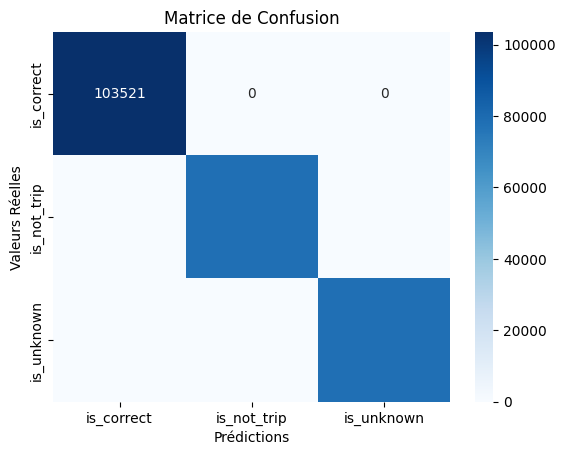

Matrice de confusion affichée.


In [38]:
# Cellule 4: Évaluation du modèle
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(cm, labels):
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title("Matrice de Confusion")
    plt.xlabel("Prédictions")
    plt.ylabel("Valeurs Réelles")
    plt.show()
    print("Matrice de confusion affichée.")

# Évaluation du modèle
def evaluate_model(model, X_test, y_test, labels):
    y_pred = model.predict(X_test)
    threshold = 0.5
    y_pred_binary = (y_pred > threshold).astype(int)

    print("\nÉvaluation sur l'ensemble de test :")
    print(classification_report(y_test, y_pred_binary, target_names=labels))

    cm = confusion_matrix(y_test.argmax(axis=1), y_pred_binary.argmax(axis=1))
    plot_confusion_matrix(cm, labels)

# Exécuter l'évaluation
print("\nÉvaluation du modèle...")
evaluate_model(model, X_test_padded, y_test, labels)

In [39]:
# Cellule 5: Prédictions sur de nouveaux textes
def predict_new_texts(model, tokenizer, new_texts, max_length, labels):
    new_texts_sequences = tokenizer.texts_to_sequences(new_texts)
    new_texts_padded = pad_sequences(new_texts_sequences, maxlen=max_length)
    predicted_labels = model.predict(new_texts_padded)

    for i, text in enumerate(new_texts):
        print(f"\nTexte: {text}")
        for j, label in enumerate(labels):
            print(f" - {label}: {round(predicted_labels[i][j] * 100, 2)}%")

# Tester sur de nouvelles phrases
new_texts = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je veux aller de Nantes à Nantes.",
    "Comment aller à Niort depuis Troyes ?"
]
predict_new_texts(model, tokenizer, new_texts, max_length, labels)

1/1 [==============================] - 0s 47ms/step

Texte: Je veux aller de Port-Boulet à Le Havre.
 - is_correct: 0.07%
 - is_not_trip: 99.28%
 - is_unknown: 0.0%

Texte: Je veux aller de Nantes à Nantes.
 - is_correct: 100.0%
 - is_not_trip: 0.0%
 - is_unknown: 0.0%

Texte: Comment aller à Niort depuis Troyes ?
 - is_correct: 0.0%
 - is_not_trip: 99.99%
 - is_unknown: 0.01%
